In [ ]:
%cd "/content/drive/MyDrive/Shatel"

/content/drive/MyDrive/Shatel


In [ ]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import json

#### Metadata

In [ ]:
train_data_path = "dataset/train.csv"
test_data_path = "dataset/test.csv"

#### Read data

In [ ]:
# Reading file and creating train and test data and labels
headers = ['contract_id', 'month', 'disconnect_count', 'usage', 'payment', 'total_call_count', \
            'problem_call_count', 'traffic_tag', 'labels']
data = pd.read_csv(train_data_path, header=None, names=headers)
# data = data.head(100002)
data.head(10)

,contract_id,month,disconnect_count,usage,payment,total_call_count,problem_call_count,traffic_tag,labels
0,1,140201,0,17.85,33656,0,0,1,1
1,1,140202,0,18.63,33656,0,0,1,1
2,1,140203,0,18.76,44174,0,0,1,1
3,1,140204,1,22.03,44174,0,0,1,1
4,1,140205,0,28.55,44174,0,0,1,1
5,1,140206,0,18.92,44174,0,0,1,1
6,2,140206,27,3.03,38437,1,0,1,1
7,2,140207,2,21.59,0,0,0,1,1
8,2,140208,27,1.58,38437,2,0,1,1
9,2,140209,3,8.63,0,0,0,1,1


#### Check and remove nan values

In [ ]:
print('Number of all rows in training data: ' + str(len(data)))
data = data.dropna()
print('Number of rows after droping nan rows in training data: ' + str(len(data)))

Number of all rows in training data: 2698218
Number of rows after droping nan rows in training data: 2698218


#### Check non numeric columns

In [ ]:
columns = list(data.columns)
for column in columns:
    if str(data[column].dtype) not in ['int64', 'float64']:
        print(column)

#### Outlier detection

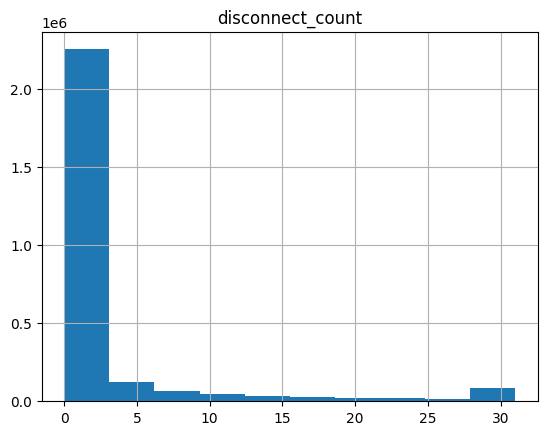

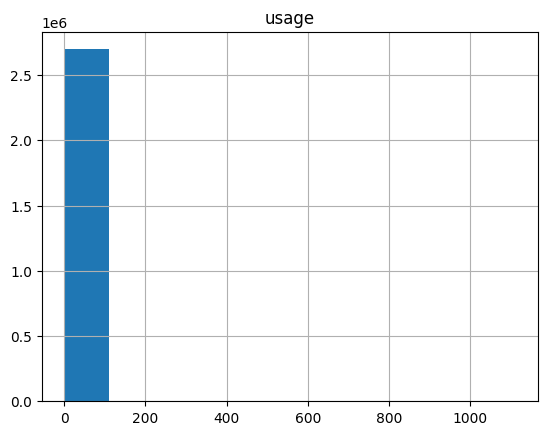

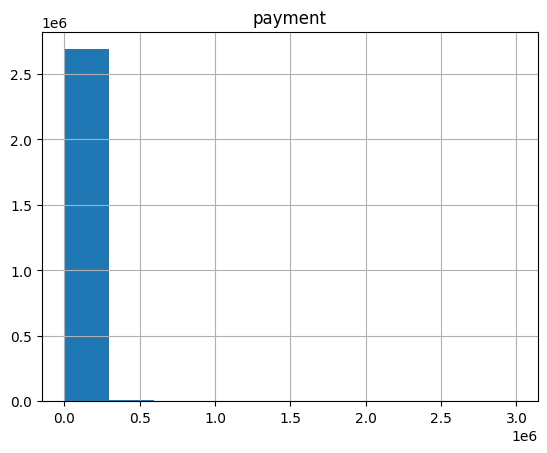

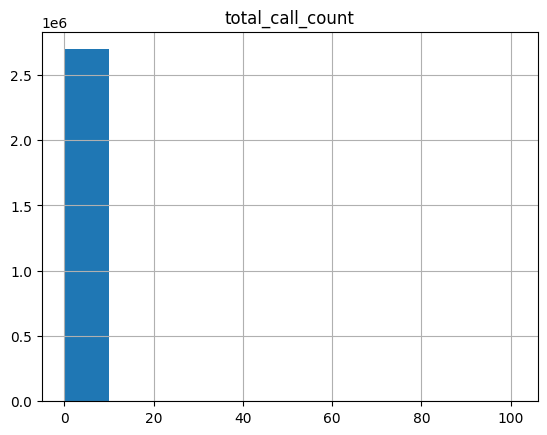

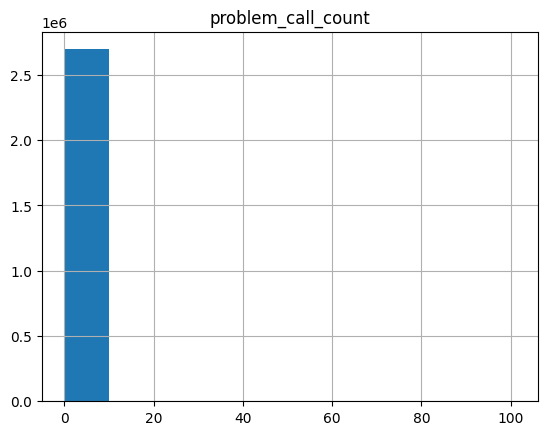

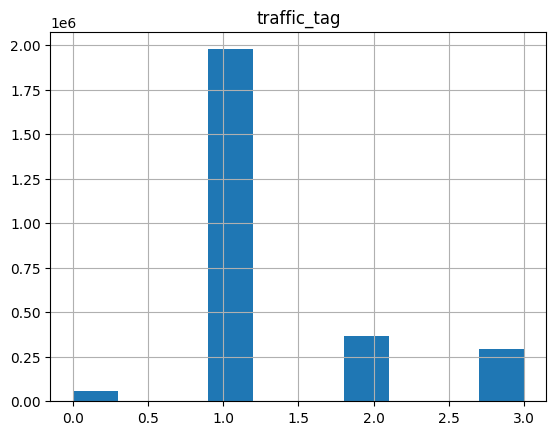

In [ ]:
cols = ['disconnect_count', 'usage', 'payment', 'total_call_count', \
            'problem_call_count', 'traffic_tag']
for col in cols:
    data.hist(column=[col])
    plt.show()

In [ ]:
print(f"Number of rows before removing outliers: {len(data)}")
removeing_users_id = data[(data["usage"]>200) | (data["payment"]>1e6) | (data["total_call_count"]>20) | (data["problem_call_count"]>20)]["contract_id"]
data = data[~data['contract_id'].isin(removeing_users_id)]
print(f"Number of rows after removing outliers: {len(removeing_users_id)}")

#### Normalize data

In [ ]:
def normalize_data(data):
    meta_data = {}
    cols = list(data.columns)
    cols.remove('contract_id')
    cols.remove('month')
    cols.remove('labels')
    for col in cols:
        mean, std = data[col].mean(), data[col].std(ddof=0)
        meta_data[col] = {"mean":mean, "std":std}
        data[col] = (data[col] - mean)/std
    with open("meta_data.json", "w") as f:
        json.dump(meta_data, f)
    return data

normalized_data = normalize_data(data)
normalized_data.head(10)

,contract_id,month,disconnect_count,usage,payment,total_call_count,problem_call_count,traffic_tag,labels
0,1,140201,-0.404477,0.797228,0.197851,-0.261257,-0.196297,-0.482489,1
1,1,140202,-0.404477,0.866417,0.197851,-0.261257,-0.196297,-0.482489,1
2,1,140203,-0.404477,0.877949,0.447350,-0.261257,-0.196297,-0.482489,1
3,1,140204,-0.251870,1.168012,0.447350,-0.261257,-0.196297,-0.482489,1
4,1,140205,-0.404477,1.746363,0.447350,-0.261257,-0.196297,-0.482489,1
5,1,140206,-0.404477,0.892142,0.447350,-0.261257,-0.196297,-0.482489,1
6,2,140206,3.715911,-0.517368,0.311262,0.963065,-0.196297,-0.482489,1
7,2,140207,-0.099263,1.128982,-0.600509,-0.261257,-0.196297,-0.482489,1
8,2,140208,3.715911,-0.645989,0.311262,2.187386,-0.196297,-0.482489,1
9,2,140209,0.053344,-0.020625,-0.600509,-0.261257,-0.196297,-0.482489,1


#### Split data of any users

In [ ]:
grouped_data = normalized_data.groupby('contract_id')
users_data, labels = [], []
for name, group in tqdm(grouped_data):
    group.sort_values('month')
    group.pop('month')
    label = group["labels"].tolist()[-1]
    label = 1-label
    group.pop('labels')
    group.pop('contract_id')
    users_data.append(group.values.flatten())
    # users_data.append(group.values[-1])
    labels.append(label)
users_data = np.array(users_data)
labels = np.array(labels)

print(f"\nNumber of new data rows: {len(users_data)}")

100%|██████████| 449703/449703 [13:05<00:00, 572.35it/s]



Number of new data rows: 449703


#### Split train and validation data

In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(users_data, labels, test_size=0.2, random_state=42)
print(f"Sape of train data: {train_data.shape}")
print(f"Sape of val data: {val_data.shape}")

Sape of train data: (359762, 36)
Sape of val data: (89941, 36)


### Decision Tree

In [ ]:
def train_decision_tree(method, depth):
    model = tree.DecisionTreeClassifier(criterion=method, max_depth=depth)
    model = model.fit(train_data, train_labels)
    return model

Depth 1: train f1-score=0.7882, val f1-score=0.7953
Depth 2: train f1-score=0.7967, val f1-score=0.8051
Depth 3: train f1-score=0.7949, val f1-score=0.8034
Depth 4: train f1-score=0.7984, val f1-score=0.8079
Depth 5: train f1-score=0.8044, val f1-score=0.8116
Depth 6: train f1-score=0.8047, val f1-score=0.8116
Depth 7: train f1-score=0.8068, val f1-score=0.8109
Depth 8: train f1-score=0.8074, val f1-score=0.8099
Depth 9: train f1-score=0.8107, val f1-score=0.8095
Depth 10: train f1-score=0.8138, val f1-score=0.8050
Depth 11: train f1-score=0.8209, val f1-score=0.8028
Depth 12: train f1-score=0.8279, val f1-score=0.7994
Depth 13: train f1-score=0.8360, val f1-score=0.7932
Depth 14: train f1-score=0.8441, val f1-score=0.7899
Depth 15: train f1-score=0.8531, val f1-score=0.7842
Depth 16: train f1-score=0.8615, val f1-score=0.7768
Depth 17: train f1-score=0.8701, val f1-score=0.7746
Depth 18: train f1-score=0.8793, val f1-score=0.7673
Depth 19: train f1-score=0.8879, val f1-score=0.7609
De

[Text(0.5270833333333333, 0.9166666666666666, 'x[30] <= 29.5\nentropy = 0.351\nsamples = 359762\nvalue = [335986, 23776]'),
 Text(0.26666666666666666, 0.75, 'x[31] <= 0.005\nentropy = 0.103\nsamples = 334690\nvalue = [330165, 4525]'),
 Text(0.13333333333333333, 0.5833333333333334, 'x[30] <= 10.5\nentropy = 0.261\nsamples = 23834\nvalue = [22783, 1051]'),
 Text(0.06666666666666667, 0.4166666666666667, 'x[32] <= 1229.0\nentropy = 0.194\nsamples = 20764\nvalue = [20142, 622]'),
 Text(0.03333333333333333, 0.25, 'x[30] <= 0.5\nentropy = 0.208\nsamples = 18238\nvalue = [17641, 597]'),
 Text(0.016666666666666666, 0.08333333333333333, 'entropy = 0.194\nsamples = 17079\nvalue = [16569, 510]'),
 Text(0.05, 0.08333333333333333, 'entropy = 0.385\nsamples = 1159\nvalue = [1072, 87]'),
 Text(0.1, 0.25, 'x[8] <= 25146.5\nentropy = 0.08\nsamples = 2526\nvalue = [2501, 25]'),
 Text(0.08333333333333333, 0.08333333333333333, 'entropy = 0.057\nsamples = 2269\nvalue = [2254, 15]'),
 Text(0.1166666666666666

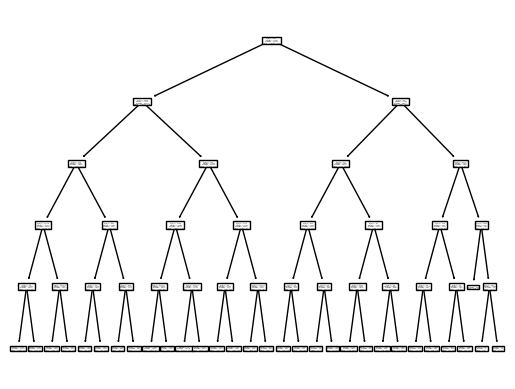

In [ ]:
best_f1_score = 0
best_depth = 0
best_model = None
best_val_results = None
for i in range(1, 21):
    model = train_decision_tree('entropy', i)
    pred_labels = model.predict(train_data)
    train_f1_score = metrics.f1_score(train_labels, pred_labels)
    pred_labels = model.predict(val_data)
    val_f1_score = metrics.f1_score(val_labels, pred_labels)
    # accurace = metrics.accuracy_score(val_labels, pred_labels)
    print('Depth {}: train f1-score={:.4f}, val f1-score={:.4f}'.format(i, train_f1_score, val_f1_score))
    if val_f1_score > best_f1_score:
        best_f1_score = val_f1_score
        best_depth = i
        best_model = model
        best_val_results = pred_labels

conf_matrix = metrics.confusion_matrix(val_labels, best_val_results)
class_report = metrics.classification_report(val_labels, best_val_results)

print(f"\nBest tree: depth={best_depth}")
print(f"f1-score={best_f1_score}")
print("confusion matrix:")
print(conf_matrix)
print("classification report:")
print(class_report)

In [ ]:
tree.plot_tree(best_model)

### Random Forest

In [ ]:
def train_random_forest(method, depth):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, criterion=method, random_state=0)
    model.fit(train_data, train_labels)  # train random forest
    return model

In [ ]:
best_f1_score = 0
best_depth = 0
best_model = None
best_val_results = None
for i in range(1, 21):
    model = train_random_forest('entropy', i)
    pred_labels = model.predict(train_data)
    train_f1_score = metrics.f1_score(train_labels, pred_labels)
    pred_labels = model.predict(val_data)
    val_f1_score = metrics.f1_score(val_labels, pred_labels)
    print('Depth {}: train f1-score={:.4f}, val f1-score={:.4f}'.format(i, train_f1_score, val_f1_score))
    if val_f1_score > best_f1_score:
        best_f1_score = val_f1_score
        best_depth = i
        best_model = model
        best_val_results = pred_labels

conf_matrix = metrics.confusion_matrix(val_labels, best_val_results)
class_report = metrics.classification_report(val_labels, best_val_results)

print(f"\nBest tree: depth={best_depth}")
print(f"f1-score={best_f1_score}")
print("confusion matrix:")
print(conf_matrix)
print("classification report:")
print(class_report)

Depth 1: train f1-score=0.0000, val f1-score=0.0000
Depth 2: train f1-score=0.7742, val f1-score=0.7851
Depth 3: train f1-score=0.7980, val f1-score=0.8040
Depth 4: train f1-score=0.8004, val f1-score=0.8080
Depth 5: train f1-score=0.8025, val f1-score=0.8101
Depth 6: train f1-score=0.8028, val f1-score=0.8097
Depth 7: train f1-score=0.8040, val f1-score=0.8105
Depth 8: train f1-score=0.8061, val f1-score=0.8117
Depth 9: train f1-score=0.8087, val f1-score=0.8119
Depth 10: train f1-score=0.8113, val f1-score=0.8123
Depth 11: train f1-score=0.8152, val f1-score=0.8131
Depth 12: train f1-score=0.8206, val f1-score=0.8124
Depth 13: train f1-score=0.8271, val f1-score=0.8139
Depth 14: train f1-score=0.8348, val f1-score=0.8129
Depth 15: train f1-score=0.8424, val f1-score=0.8134
Depth 16: train f1-score=0.8500, val f1-score=0.8138
Depth 17: train f1-score=0.8591, val f1-score=0.8129
Depth 18: train f1-score=0.8661, val f1-score=0.8124
Depth 19: train f1-score=0.8742, val f1-score=0.8140
De

### SVM

In [ ]:
def train_svm(kernel, param):
    model = svm.SVC(kernel=kernel, **param)
    model = svm.LinearSVC(**param, max_iter=10000, dual=False)
    model.fit(train_data, train_labels)
    return model

In [ ]:
best_f1_score = 0
best_params = {}
best_model = None
best_val_results = None
kernel2params = {
    "linear": [{"C": C} for C in [0.01, 0.1, 1, 10, 100, 1000]]
}

for kernel, all_params in kernel2params.items():
    print("#"*50)
    print(f"Kernel: {kernel}")
    for params in all_params:
        model = train_svm(kernel, params)
        pred_labels = model.predict(train_data)
        train_f1_score = metrics.f1_score(train_labels, pred_labels)
        pred_labels = model.predict(val_data)
        val_f1_score = metrics.f1_score(val_labels, pred_labels)
        print('\t Parameters {}: train f1-score={:.4f}, val f1-score={:.4f}'.format(params, train_f1_score, val_f1_score))
        if val_f1_score > best_f1_score:
            best_f1_score = val_f1_score
            best_params = params
            best_model = model
            best_val_results = pred_labels

conf_matrix = metrics.confusion_matrix(val_labels, best_val_results)
class_report = metrics.classification_report(val_labels, best_val_results)

print(f"\nBest params: depth={best_params}")
print(f"f1-score={best_f1_score}")
print("confusion matrix:")
print(conf_matrix)
print("classification report:")
print(class_report)

##################################################
Kernel: linear
	 Parameters {'C': 0.01}: train f1-score=0.7953, val f1-score=0.8028
	 Parameters {'C': 0.1}: train f1-score=0.7952, val f1-score=0.8028
	 Parameters {'C': 1}: train f1-score=0.7952, val f1-score=0.8028
	 Parameters {'C': 10}: train f1-score=0.7952, val f1-score=0.8028
	 Parameters {'C': 100}: train f1-score=0.7952, val f1-score=0.8028
	 Parameters {'C': 1000}: train f1-score=0.7952, val f1-score=0.8028

Best params: depth={'C': 0.01}
f1-score=0.8028156923341059
confusion matrix:
[[82968  1020]
 [ 1277  4676]]
classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     83988
           1       0.82      0.79      0.80      5953

    accuracy                           0.97     89941
   macro avg       0.90      0.89      0.89     89941
weighted avg       0.97      0.97      0.97     89941

